# Demonstration File

In [1]:
#Import necessary libraries
import test_manifold_algorithms as tma
from MASH import MASH
from SPUD import SPUD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Prep the domains
dc = tma.test_manifold_algorithms("seeds.csv", split = "even", verbose = 3, random_state=2816)



 
 
---------------------------       Initalizing class with seeds.csv data       ---------------------------

Spliting the data evenly
Split A features shape: (199, 4)
Split B Features shape (199, 3)
MDS initialized with 3 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


# Testing with Timeless Variables

In [2]:
import pandas as pd
timeless = pd.read_csv(r"C:\Users\jcory\Box\Graph-Manifold-Alignment\CSV Files\Timeless Variables 2024-07-09.csv")
timeless = timeless.fillna(-4).drop(columns = ["PTRACCAT", "DX_bl", "PTMARRY"])

In [3]:
timeless.sample(5)

,RID,PTEDUCAT,PTHAND,MOTHAD,FATHAD,MOTHDEM,FATHDEM,AGE,PHS,CIR,...,PXMUSCUL,PXBACK,PXOTHER,PTGENDER,PTDOBYY,PTPLANG,PTETHCAT,PTIDENT,PTENGSPK,PTETHCATH
3912,6788,19.0,1.0,-4.0,1.0,0.0,1.0,69.7,-4.000000,-4.000000,...,1.0,1.0,1.0,1.0,1949.0,1.0,2.0,-4.0,-4.0,-4.0
1851,4016,20.0,1.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.000000,-4.000000,...,1.0,1.0,1.0,1.0,1931.0,1.0,2.0,-4.0,-4.0,-4.0
2777,4943,20.0,1.0,-4.0,-4.0,-4.0,-4.0,76.1,0.602536,0.109992,...,2.0,1.0,1.0,1.0,1936.0,1.0,2.0,-4.0,-4.0,-4.0
1271,1277,11.0,1.0,-4.0,-4.0,-4.0,-4.0,86.3,1.793010,1.521590,...,1.0,-4.0,1.0,1.0,1920.0,1.0,2.0,-4.0,-4.0,-4.0
290,292,16.0,1.0,-4.0,-4.0,-4.0,-4.0,76.4,-4.000000,-4.000000,...,1.0,1.0,1.0,1.0,1929.0,1.0,2.0,-4.0,-4.0,-4.0


In [4]:
len(timeless.columns), len(timeless)

(32, 4385)

In [5]:
np.array(timeless)[:, 1]

array([18., 16., 18., ...,  8., -4., -4.])

In [6]:
domain_a = np.array(timeless)[:200, :10].astype(float)
domain_b = np.array(timeless)[:200, 10:].astype(float)

In [7]:
dc.anchors[:22]

array([[115, 115],
       [ 54,  54],
       [ 85,  85],
       [ 70,  70],
       [ 40,  40],
       [186, 186],
       [100, 100],
       [191, 191],
       [110, 110],
       [137, 137],
       [183, 183],
       [176, 176],
       [114, 114],
       [134, 134],
       [118, 118],
       [ 77,  77],
       [153, 153],
       [ 16,  16],
       [ 38,  38],
       [ 44,  44],
       [ 11,  11],
       [ 14,  14]])

In [8]:
domain_a.shape

(200, 10)

In [11]:
spud_time = SPUD(knn = 2, verbose = 2)

In [12]:
spud_time.fit(dataA = domain_a, dataB = domain_b, known_anchors=dc.anchors[:22])

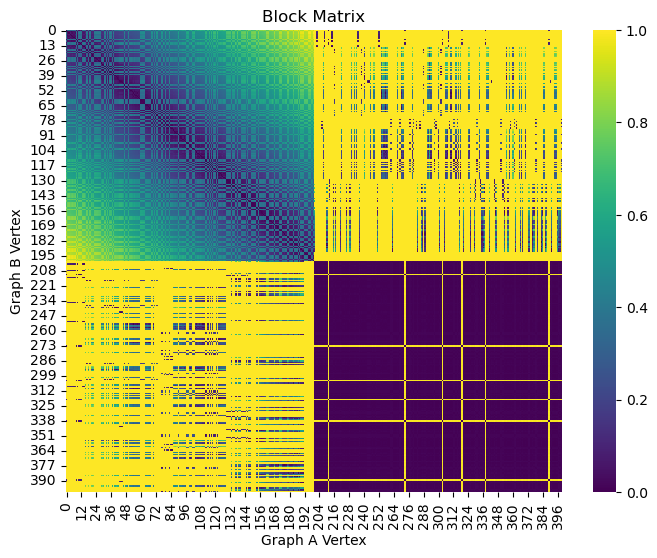

In [14]:
spud_time.plot_heat_map()

Cross Embedding: 0.5075
FOSCTTM: 0.40025


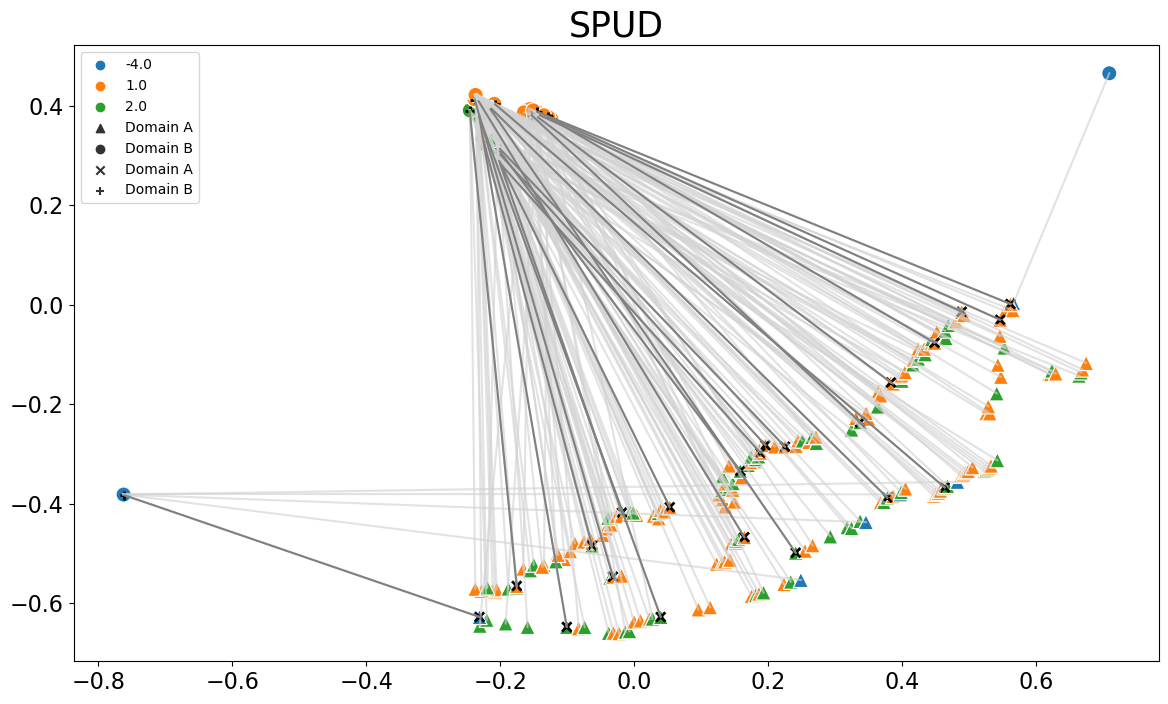

In [34]:
#timeless = pd.read_csv("/yunity/arusty/Graph-Manifold-Alignment/Python_Files/Timeless.csv")

spud_time.plot_emb(labels = pd.concat([timeless["PTGENDER"][:200], timeless["PTGENDER"][:200]]))

# Testing with Timeless and Timefull variables

In [57]:
#Create dataclasses. Note, we want to distort to leave domain unchanged
timeless_data = tma.test_manifold_algorithms("Data Files\Timeless Variables 2024-07-22.xlsx", split = "distort", verbose = 3, random_state=2816)
visits_data = tma.test_manifold_algorithms("Visit Variables 2024-07-09.csv", split = "distort", verbose = 3, random_state=2816)


 
 
---------------------------       Initalizing class with Data Files\Timeless Variables 2024-07-22.xlsx data       ---------------------------



FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\jcory\\Box\\Graph-Manifold-Alignment/CSV Files/Data Files\\Timeless Variables 2024-07-22.xlsx'

In [17]:
SUBSET_VAL = 20

In [18]:
#Read in the visits data to get the RDI
visits_labels = pd.read_csv(r"C:\Users\jcory\Box\Graph-Manifold-Alignment\CSV Files\Visit Variables 2024-07-09.csv")["RID"].values

#Create the anchors and make sure that each person coordinates with another person
TV_anchors = np.array([(visits_labels[x]-1, x) for x in range(0, len(visits_labels)) if visits_labels[x]-1 < len(timeless_data.labels[:SUBSET_VAL])]) #[:300] this gets removed when we stop the subset

In [19]:
#Reset NaN values to be -4 :)
timeless_data.split_A[np.isnan(timeless_data.split_A)] = -4
visits_data.split_A[np.isnan(visits_data.split_A)] = -4

#Lets subset the data
timeless_data.split_A = timeless_data.split_A[:SUBSET_VAL]
visits_data.split_A = visits_data.split_A[:max(TV_anchors[:, 1])+1]

In [54]:
timeless_data.split_A

array([[ 0.88235294, -4.        , -4.        , -4.        , -4.        ,
        -4.        ,  0.        , -4.        ,  0.        , -4.        ,
        -4.        , -4.        , -4.        , -4.        , -4.        ,
        -4.        , -4.        , -4.        , -4.        , -4.        ,
        -4.        , -4.        , -4.        , -4.        , -4.        ,
        -4.        ,  1.        ,  0.26605505, -4.        , -4.        ,
         0.        , -4.        , -4.        , -4.        ],
       [ 0.76470588,  1.        , -4.        , -4.        , -4.        ,
        -4.        ,  0.4       ,  0.58292683,  0.4       ,  0.32004372,
         0.01510422, -4.        , -4.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.14678899,  0.        ,  0.5       ,
         0.81818182, -4.        , -4.        , -4.        ],
  

In [46]:
len(TV_anchors), len(timeless_data.split_A), len(visits_data.split_A), max(TV_anchors[:, 1])

(125, 20, 125, 124)

In [21]:
TV_anchors[-10:]

array([[ 18, 115],
       [ 18, 116],
       [ 18, 117],
       [ 18, 118],
       [ 18, 119],
       [ 18, 120],
       [ 18, 121],
       [ 18, 122],
       [ 18, 123],
       [ 18, 124]], dtype=int64)

In [22]:
#Create the merged values --> This will take up the rest of your day
tv = SPUD(n_pca = 10)
tv.fit(timeless_data.split_A, visits_data.split_A, known_anchors = TV_anchors)

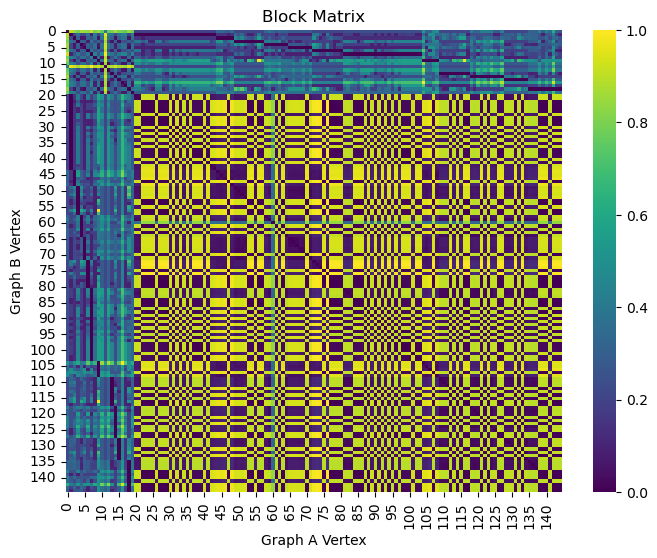

In [24]:
tv.plot_heat_map()

In [47]:
labels = pd.concat([timeless["PTGENDER"][:20], timeless["PTGENDER"][:125]])

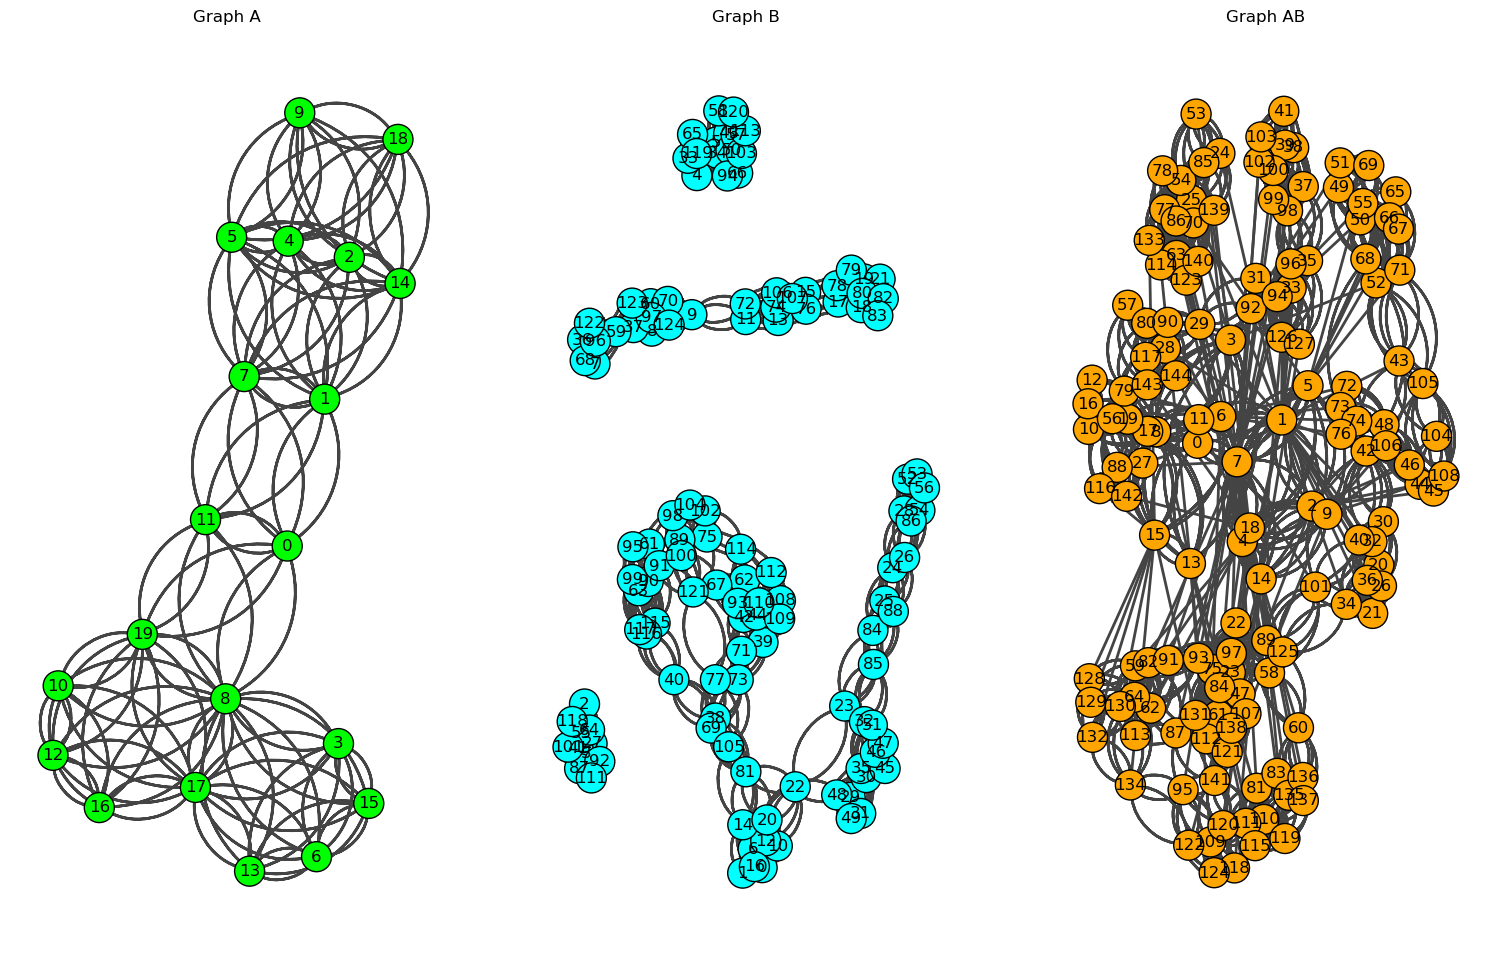

Cross Embedding: 0.544
Can't compute FOSCTTM with different domain shapes.


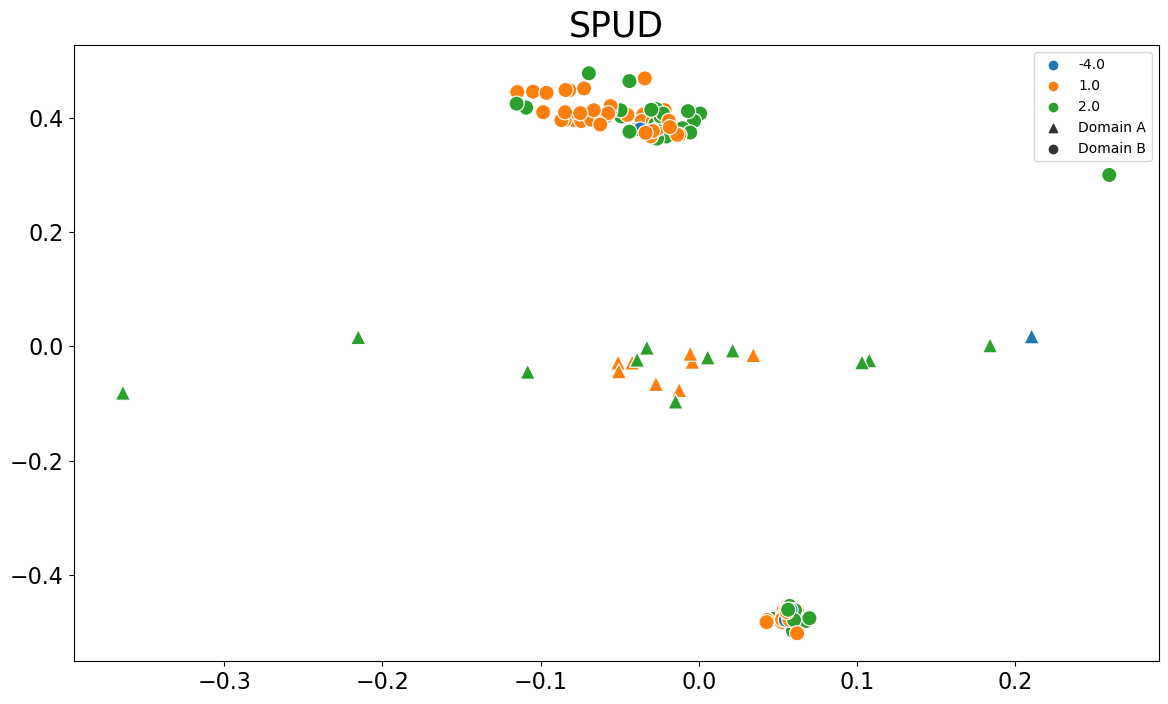

In [52]:
tv.plot_graphs()

tv.plot_emb(labels = labels, show_anchors = False, show_lines = False, n_comp = 2)